In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import winsound
import warnings
import xml.etree.ElementTree as ET
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, ConvLSTM1D, TimeDistributed, Flatten, Dropout, RepeatVector, Activation, ReLU, BatchNormalization
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras

from math import sqrt

%matplotlib inline

### Importing data

In [13]:
import pandas as pd

df = pd.read_csv('C:\\Users\\Giova\\OneDrive\\Desktop\\UNIPI\\MAGISTRALE\\TESI MAGISTRALE\\all_data')


In [14]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

In [6]:
# df.drop(['Ora_sin', 'Ora_cos'], axis=1, inplace=True)

In [15]:
def yearly_dataset(df, year):
    return df[df.index.year == year]

In [17]:
df_PUN = df.iloc[:, :3]
df_GAS = df.iloc[:, :5]
df_total_load = df.iloc[:, :7]
df_PUN7 = df.iloc[:,:2]

#### Defining functions

In [18]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                             target_size, step, single_step=False):

    data = []
    labels = []

    # Aggiusta l'indice di partenza in base alla dimensione della storia
    # start_index = start_index + history_size

    if start_index is None:
        start_index = 0

    # Imposta l'indice di fine se non è specificato
    if end_index is None:
        end_index = len(dataset) - target_size
        
    
    for i in range(start_index, end_index, step):
        indices = range(i, i + history_size)
        data.append(dataset[indices])
        
        # Aggiunge l'etichetta in base al tipo di previsione
        if single_step:
            labels.append(target[i + history_size + target_size])
        else:
            labels.append(target[i + history_size: i + history_size + target_size])

        # check if we are beyond the dataset
        if i + history_size > len(dataset) - target_size - history_size:
            break
    

    return np.array(data), np.array(labels)

In [19]:
def single_timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    nmae = NMAE_error(y_true, y_pred)

    dec = 3 # cifra di approssimazione

    print('Evaluation metric results:-')
    print(f'MAE is : {round(mae, dec)}')
    print(f'RMSE is : {round(rmse, dec)}')
    print(f'MAPE is : {round(mape, dec)}')
    print(f'NMAE is : {round(nmae, dec)}')
    # print(f'R2 is : {round(metrics.r2_score(y_true, y_pred), 2)}', end='\n\n')

def NMAE_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return metrics.mean_absolute_error(y_true, y_pred) / np.mean(np.abs(y_true))



In [20]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        mask = y_true != 0  # Crea una maschera per evitare divisione per zero
        y_true_masked = y_true[mask]
        y_pred_masked = y_pred[mask]
        return np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100

    def NMAE_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return metrics.mean_absolute_error(y_true, y_pred)/np.mean(np.abs(y_true))
   
    mae_values = []
    rmse_values = []
    mape_values = []
    nmae_values = []
    dec = 3 #cifre decimali
    
    for col_idx in range(y_true.shape[1]):
        col_true = y_true[:, col_idx]
        col_pred = y_pred[:, col_idx]
        
        
        mae_values.append(metrics.mean_absolute_error(col_true, col_pred))
        rmse_values.append(np.sqrt(metrics.mean_squared_error(col_true, col_pred)))
        mape_values.append(mean_absolute_percentage_error(col_true, col_pred))
        nmae_values.append(NMAE_error(col_true, col_pred))

    print('Evaluation metric results:')
    print(f'MAE is : {round(np.mean(mae_values), dec)}')
    print(f'RMSE is : {round(np.mean(rmse_values), dec)}')
    print(f'MAPE is : {round(np.mean(mape_values), dec)}')
    print(f'NMAE is : {round(np.mean(nmae_values), dec)}', end='\n\n')


In [21]:
def plot_model_loss(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [22]:
def plot_error_metrics(error_table):
    # Creazione dei subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    # Plot per NMAE
    ax1.scatter(error_table['Column'], error_table['NMAE'], label='NMAE', alpha=0.7, marker='o')
    ax1.set_xlabel('Columns')
    ax1.set_ylabel('NMAE')
    ax1.set_title('NMAE for Each Column')
    ax1.legend()

    # Plot per MAE, RMSE, MAPE
    ax2.scatter(error_table['Column'], error_table['RMSE'], label='RMSE', alpha=0.7, marker='o')
    ax2.scatter(error_table['Column'], error_table['MAPE'], label='MAPE', alpha=0.7, marker='o')
    ax2.set_xlabel('Columns')
    ax2.set_ylabel('Errors')
    ax2.set_title('RMSE and MAPE for Each Column')
    ax2.legend()

    # Trova il minimo di NMAE, RMSE e MAPE
    min_nmae_row = error_table.loc[error_table['NMAE'].idxmin()]
    min_rmse_row = error_table.loc[error_table['RMSE'].idxmin()]
    min_mape_row = error_table.loc[error_table['MAPE'].idxmin()]

    # Stampa i minimi e le relative colonne
    print("Min NMAE:", min_nmae_row['NMAE'], "for Column:", min_nmae_row['Column'])
    print("Min RMSE:", min_rmse_row['RMSE'], "for Column:", min_rmse_row['Column'])
    print("Min MAPE:", min_mape_row['MAPE'], "for Column:", min_mape_row['Column'])


    plt.tight_layout()
    plt.show()


In [14]:
def visual_single_timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    nmae = NMAE_error(y_true, y_pred)

    dec = 3  # cifra di approssimazione

    result = {
        'RMSE': round(rmse, dec),
        'MAPE': round(mape, dec),
        'NMAE': round(nmae, dec)
    }

    return result


In [15]:
def evaluate_and_plot_timeseries(y_test_inv, forecast, show_plot=False):
    # locals()['error_list' + forecast] = []
    error_list = []

    if show_plot:
        fig, axes = plt.subplots(y_test_inv.shape[1], 1, figsize=(16, 4 * y_test_inv.shape[1]))

    for col_idx in range(forecast.shape[1]):
        col_true = y_test_inv[:, col_idx]
        col_pred = forecast[:, col_idx]

        # Calcola le metriche per la colonna corrente
        metrics_result = visual_single_timeseries_evaluation_metrics_func(col_true, col_pred)

        # Estrai gli errori dalla risultato della funzione
        rmse, mape, nmae = metrics_result.values()

        # Aggiungi gli errori alla lista
        error_list.append({'Column': col_idx, 'RMSE': rmse, 'MAPE': mape, 'NMAE': nmae})

        # Plot per la colonna corrente (Actual vs Forecast)
        if show_plot:
            axes[col_idx].plot(col_true, linewidth=0.7, label='Actual')
            axes[col_idx].plot(col_pred, linewidth=0.7, color='r', label=f'Forecast (Column {col_idx})')
            axes[col_idx].set_xlabel('Date')
            axes[col_idx].set_ylabel(f'PUN forecasting (Column {col_idx})')
            axes[col_idx].set_title(f'Raw Data and Prediction (Column {col_idx})')
            axes[col_idx].legend()

    # Converti la lista in DataFrame alla fine
    error_table = pd.DataFrame(error_list)

    
    # # Mostra i plot
    # plt.tight_layout()
    # plt.show()
    
    return error_table
    


In [16]:
def plot_error_metrics_barchart(error_table):
    # Creazione dei subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    # Grafico a barre per NMAE
    ax1.bar(error_table['Column'], error_table['NMAE'], color='blue', alpha=0.7)
    ax1.set_xlabel('Columns')
    ax1.set_ylabel('NMAE')
    ax1.set_title('NMAE for Each Column')

    # Grafico a barre per MAE, RMSE, MAPE
    # ax2.bar(error_table['Column'] - 0.2, error_table['MAE'], width=0.2, color='green', label='MAE', alpha=0.7)
    ax2.bar(error_table['Column'], error_table['RMSE'], width=0.2, color='orange', label='RMSE', alpha=0.7)
    ax2.bar(error_table['Column'] + 0.2, error_table['MAPE'], width=0.2, color='red', label='MAPE', alpha=0.7)
    ax2.set_xlabel('Columns')
    ax2.set_ylabel('Errors')
    ax2.set_title('RMSE and MAPE for Each Column')
    ax2.legend()

    # Trova il minimo di NMAE, RMSE e MAPE
    min_nmae_row = error_table.loc[error_table['NMAE'].idxmin()]
    min_rmse_row = error_table.loc[error_table['RMSE'].idxmin()]
    min_mape_row = error_table.loc[error_table['MAPE'].idxmin()]

    # Stampa i minimi e le relative colonne
    print("Min NMAE:", min_nmae_row['NMAE'], "for Column:", min_nmae_row['Column'])
    print("Min RMSE:", min_rmse_row['RMSE'], "for Column:", min_rmse_row['Column'])
    print("Min MAPE:", min_mape_row['MAPE'], "for Column:", min_mape_row['Column'])
    print((min_nmae_row['NMAE'], min_nmae_row['RMSE'], min_nmae_row['MAPE']))
    plt.tight_layout()
    plt.show()


In [17]:
def prepare_data(dataset_input, univariate=False):
    # Estrae la variabile target 'PUN'
    if univariate:
        X = dataset_input['PUN'].values.reshape(-1, 1)
    else:
        X = dataset_input.values

    y = dataset_input['PUN'].values.reshape(-1, 1)

    return X, y

#### Preparing data 

In [58]:
dataset_input = yearly_dataset(df_PUN, 2023)
dataset_input = df_PUN7

target_size = 24
past_history = 24
train_size = 0.7
test_size = 0.3
step = 1

# Divide il dataset in training, validation e test set
train_index = int(len(dataset_input) * train_size)
test_index = train_index + int(len(dataset_input) * test_size)

X, y = prepare_data(dataset_input, univariate=False)

X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)

y_norm = y_norm.squeeze()



# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X_norm, y_norm,
                                    0, train_index, past_history,
                                    past_history, step=step, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                train_index, test_index, past_history,
                                past_history, step=step, single_step=False)

# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# shift + tab per sdentare

y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


X_train shape: (17656, 24, 2)
y_train shape: (17656, 24)
X_test shape: (7498, 24, 2)
y_test shape: (7498, 24)


In [59]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x,x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [60]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks,
                mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(target_size)(x)
    return keras.Model(inputs, outputs)

In [61]:
from keras import layers

model = build_model(
    input_shape,
    head_size=24,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.2,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=2e-3,\
    restore_best_weights=True)]


prova con lstm

In [50]:
# def transformer_encoder_lstm(inputs, head_size, num_heads, ff_dim, lstm_units, dropout=0):
#     # Normalization and Attention
#     x = layers.LayerNormalization(epsilon=1e-6)(inputs)
#     x = layers.MultiHeadAttention(
#         key_dim=head_size, num_heads=num_heads, dropout=dropout
#     )(x, x)
#     x = layers.Dropout(dropout)(x)
#     res = x + inputs

#     # LSTM Part
#     x = layers.LayerNormalization(epsilon=1e-6)(res)
#     x = layers.LSTM(lstm_units, return_sequences=True)(x)
#     x = layers.Dropout(dropout)(x)
#     x = layers.LSTM(lstm_units)(x)

#     return x + res

# def build_model_lstm(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks,
#                      lstm_units, mlp_units, dropout=0, mlp_dropout=0):
#     inputs = keras.Input(shape=input_shape)
#     x = inputs
#     for _ in range(num_transformer_blocks):
#         x = transformer_encoder_lstm(x, head_size, num_heads, ff_dim, lstm_units, dropout)

#     x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
#     for dim in mlp_units:
#         x = layers.Dense(dim, activation="relu")(x)
#         x = layers.Dropout(mlp_dropout)(x)
#     outputs = layers.Dense(1)(x)
#     return keras.Model(inputs, outputs)


# input_shape = X_train.shape[1:]

# model = build_model_lstm(
#     input_shape,
#     head_size=24,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     lstm_units=64,  # Imposta il numero di unità LSTM come desiderato
#     mlp_units=[128],
#     mlp_dropout=0.2,
#     dropout=0.25,
# )

# model.compile(
#     loss="mean_squared_error",
#     optimizer=keras.optimizers.Adam(learning_rate=1e-5)
# )

# callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=2e-3, restore_best_weights=True)]




In [62]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=64,
    callbacks=callbacks,
)

winsound.Beep(1500, 800)



Epoch 1/60
221/221 [==============================] - 19s 49ms/step - loss: 1.1371 - val_loss: 0.4160
Epoch 2/60
221/221 [==============================] - 10s 44ms/step - loss: 0.7736 - val_loss: 0.2761
Epoch 3/60
221/221 [==============================] - 9s 41ms/step - loss: 0.5871 - val_loss: 0.2094
Epoch 4/60
221/221 [==============================] - 9s 43ms/step - loss: 0.4857 - val_loss: 0.1756
Epoch 5/60
221/221 [==============================] - 9s 41ms/step - loss: 0.4174 - val_loss: 0.1549
Epoch 6/60
221/221 [==============================] - 9s 41ms/step - loss: 0.3695 - val_loss: 0.1418
Epoch 7/60
221/221 [==============================] - 9s 41ms/step - loss: 0.3324 - val_loss: 0.1324
Epoch 8/60
221/221 [==============================] - 9s 40ms/step - loss: 0.2998 - val_loss: 0.1248
Epoch 9/60
221/221 [==============================] - 9s 40ms/step - loss: 0.2789 - val_loss: 0.1185
Epoch 10/60
221/221 [==============================] - 9s 40ms/step - loss: 0.2575 - val_

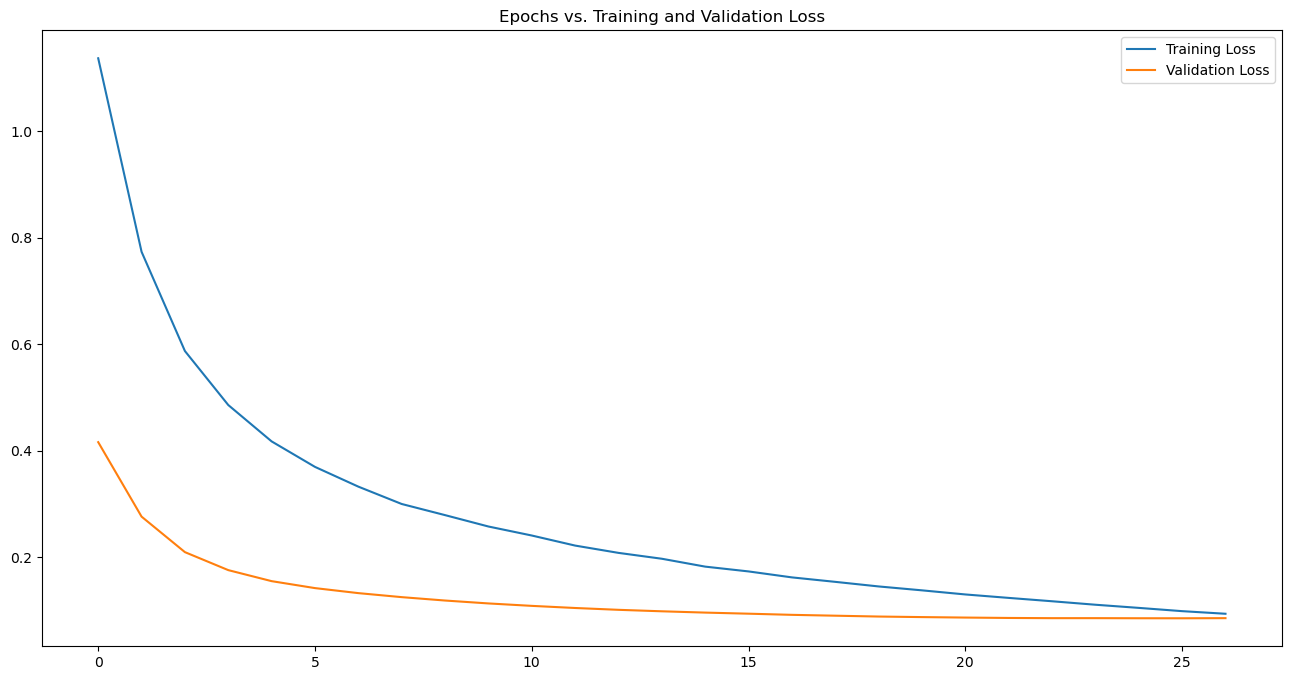

In [63]:
plot_model_loss(history)

In [64]:
forecast = model.predict(X_test)
transforecast = y_sc.inverse_transform(forecast)

235/235 [==============================] - 2s 8ms/step


In [55]:
visual_single_timeseries_evaluation_metrics_func(y_test_inv[:,0], transforecast[:,0])

{'RMSE': 31.412, 'MAPE': 27.009, 'NMAE': 0.184}

In [65]:
# Estrai le date e i dati corrispondenti
dates_train = dataset_input.index[:int(len(dataset_input) * train_size)]
dates_test = dataset_input.index[int(len(dataset_input) * train_size):]

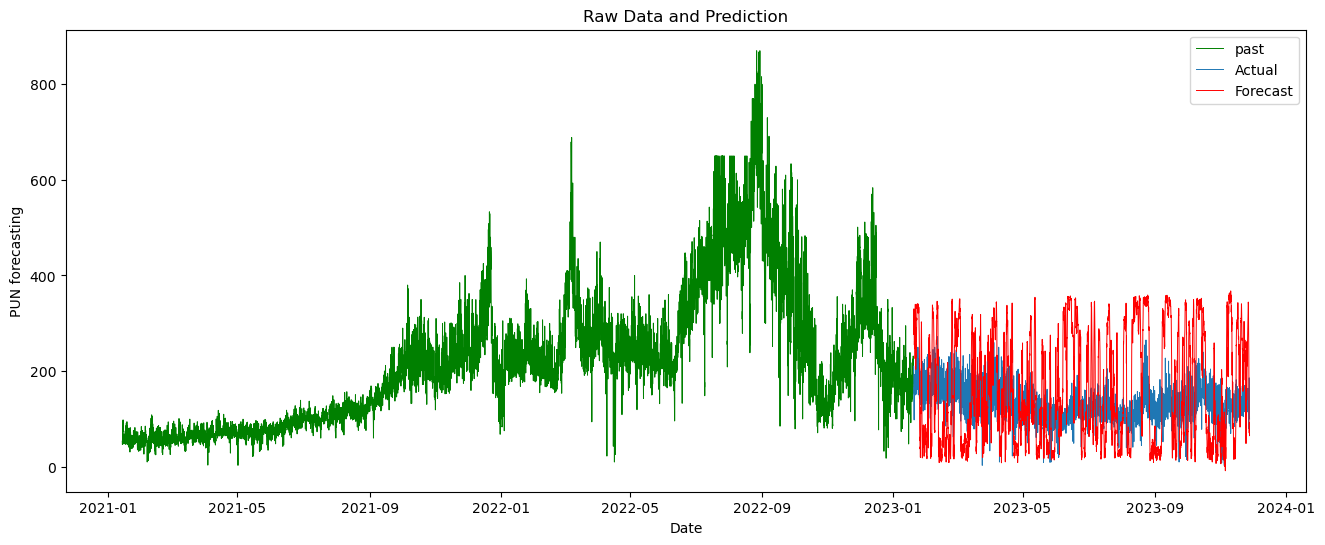

In [66]:
# A visual representation
plt.figure(figsize=(16, 6))
plt.plot(dates_train, y_sc.inverse_transform(y_train)[:,0], linewidth=0.7, color='g', label='past')
plt.plot(dates_test[:len(y_test)], y_test_inv[:,0], linewidth=0.7, label='Actual')
plt.plot(dates_test[:len(y_test)], transforecast[:,0], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()

In [2]:
import keras_tuner as kt

In [ ]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor

import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
import pandas as pd

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
from typing import Optional, Any, Union, Callable, Tuple
from pathlib import Path
import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Designing Time Series Transformer

In [20]:
class PositionalEncoder(nn.Module):
    """
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    https://github.com/LiamMaclean216/Pytorch-Transfomer/blob/master/utils.py 
    """

    def __init__(self, dropout: float = 0.1, max_seq_len: int = 24*31, d_model: int = 24):

        """
        Args:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        # Create constant positional encoding matrix with values 
        # dependent on position and i
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        exp_input = torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        
        div_term = torch.exp(exp_input) # Returns a new tensor with the exponential of the elements of exp_input
        
        pe = torch.zeros(max_seq_len, d_model)

        pe[:, 0::2] = torch.sin(position * div_term)
        
        pe[:, 1::2] = torch.cos(position * div_term) # torch.Size([target_seq_len, dim_val])

        pe = pe.unsqueeze(0).transpose(0, 1) # torch.Size([target_seq_len, input_size, dim_val])

        # register that pe is not a model parameter
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val]
        """

        add = self.pe[:x.size(1), :].squeeze(1)

        x = x + add

        return self.dropout(x)

In [22]:
class TimeSeriesTransformer(nn.Module):


    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        max_seq_len: int,
        out_seq_len: int=58,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.2,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            max_seq_len: int, length of the longest sequence the model will 
                         receive. Used in positional encoding. 
            out_seq_len: int, the length of the model's output (i.e. the target
                         sequence length)
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer 
                                     of the decoder
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len
#         self.pe = PositionalEncoder()

        print("input_size is: {}".format(input_size))
        print("dim_val is: {}".format(dim_val))

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )  

        self.linear_mapping = nn.Linear(
            in_features=out_seq_len*dim_val,
            out_features=out_seq_len
            )

        # Create positional encoder   ###changed
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc,
            max_seq_len=max_seq_len
            )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=True
            )

        # Stack the encoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=True
            )

        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the feature number
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, E is the feature number.
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src)

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src)

        # Pass through all the stacked encoder layers in the encoder
        # Masking is only needed in the encoder if input sequences are padded
        # which they are not in this time series use case, because all my
        # input sequences are naturally of the same length. 
        # (https://github.com/huggingface/transformers/issues/4083)
        src = self.encoder(
            src=src
            )

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt)

        # Pass throguh decoder
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        # Pass through the linear mapping layer
        decoder_output= self.linear_mapping(decoder_output.flatten(start_dim=1))

        return decoder_output

Initiate Transformers

In [24]:
## Model parameters
dim_val = 24 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 1 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 24 # length of input given to decoder. Can have any integer value.
enc_seq_len = 24 # length of input given to encoder. Can have any integer value.
output_sequence_length = 24 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    max_seq_len=max_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads)

input_size is: 1
dim_val is: 24


Data Preparation for transformer model

In [25]:
class TransformerDataset(Dataset):
    """
    Dataset class used for transformer models.
    
    """
    def __init__(self, 
        data: torch.tensor,
        indices: list, 
        enc_seq_len: int, 
        dec_seq_len: int, 
        target_seq_len: int
        ) -> None:

        """
        Args:
            data: tensor, the entire train, validation or test data sequence 
                        before any slicing. If univariate, data.size() will be 
                        [number of samples, number of variables]
                        where the number of variables will be equal to 1 + the number of
                        exogenous variables. Number of exogenous variables would be 0
                        if univariate.
            indices: a list of tuples. Each tuple has two elements:
                     1) the start index of a sub-sequence
                     2) the end index of a sub-sequence. 
                     The sub-sequence is split into src, trg and trg_y later.  
            enc_seq_len: int, the desired length of the input sequence given to the
                     the first layer of the transformer model.
            target_seq_len: int, the desired length of the target sequence (the output of the model)
            target_idx: The index position of the target variable in data. Data
                        is a 2D tensor
        """
        
        super().__init__()

        self.indices = indices

        self.data = data

        print("From get_src_trg: data size = {}".format(data.size()))

        self.enc_seq_len = enc_seq_len

        self.dec_seq_len = dec_seq_len

        self.target_seq_len = target_seq_len



    def __len__(self):
        
        return len(self.indices)

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        # Get the first element of the i'th tuple in the list self.indicesasdfas
        start_idx = self.indices[index][0]

        # Get the second (and last) element of the i'th tuple in the list self.indices
        end_idx = self.indices[index][1]

        sequence = self.data[start_idx:end_idx]

        #print("From __getitem__: sequence length = {}".format(len(sequence)))

        src, trg, trg_y = self.get_src_trg(
            sequence=sequence,
            enc_seq_len=self.enc_seq_len,
            dec_seq_len=self.dec_seq_len,
            target_seq_len=self.target_seq_len
            )

        return src, trg, trg_y
    
    def get_src_trg(
        self,
        sequence: torch.Tensor, 
        enc_seq_len: int, 
        dec_seq_len: int, 
        target_seq_len: int
        ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:

        """
        Generate the src (encoder input), trg (decoder input) and trg_y (the target)
        sequences from a sequence. 
        Args:
            sequence: tensor, a 1D tensor of length n where 
                    n = encoder input length + target sequence length  
            enc_seq_len: int, the desired length of the input to the transformer encoder
            target_seq_len: int, the desired length of the target sequence (the 
                            one against which the model output is compared)
        Return: 
            src: tensor, 1D, used as input to the transformer model
            trg: tensor, 1D, used as input to the transformer model
            trg_y: tensor, 1D, the target sequence against which the model output
                is compared when computing loss. 
        
        """
        assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"
        
        # encoder input
        src = sequence[:enc_seq_len] 
        
        # decoder input. As per the paper, it must have the same dimension as the 
        # target sequence, and it must contain the last value of src, and all
        # values of trg_y except the last (i.e. it must be shifted right by 1)
        trg = sequence[enc_seq_len-1:len(sequence)-1]
        
        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:]

        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

        return src, trg, trg_y.squeeze(-1) # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len]

In [26]:
def generate_square_subsequent_mask(dim1: int, dim2: int, dim3: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Modified from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, batch_size * n_heads
        dim2: int. For src and trg masking this must be target sequence length. 
        dim3: int. For src masking, this must be encoder sequence length.
              For trg masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2, dim3]
    """
    return torch.triu(torch.ones(dim1, dim2, dim3) * float('-inf'), diagonal=1)

In [27]:
def get_indices_input_target(num_obs, input_len, step_size, forecast_horizon, target_len):
        """
        Produce all the start and end index positions of all sub-sequences.
        The indices will be used to split the data into sub-sequences on which 
        the models will be trained. 
        Returns a tuple with four elements:
        1) The index position of the first element to be included in the input sequence
        2) The index position of the last element to be included in the input sequence
        3) The index position of the first element to be included in the target sequence
        4) The index position of the last element to be included in the target sequence
        
        Args:
            num_obs (int): Number of observations in the entire dataset for which
                            indices must be generated.
            input_len (int): Length of the input sequence (a sub-sequence of 
                             of the entire data sequence)
            step_size (int): Size of each step as the data sequence is traversed.
                             If 1, the first sub-sequence will be indices 0-input_len, 
                             and the next will be 1-input_len.
            forecast_horizon (int): How many index positions is the target away from
                                    the last index position of the input sequence?
                                    If forecast_horizon=1, and the input sequence
                                    is data[0:10], the target will be data[11:taget_len].
            target_len (int): Length of the target / output sequence.
        """

        input_len = round(input_len) # just a precaution
        start_position = 0
        stop_position = num_obs-1 # because of 0 indexing
        
        subseq_first_idx = start_position
        subseq_last_idx = start_position + input_len
        target_first_idx = subseq_last_idx + forecast_horizon
        target_last_idx = target_first_idx + target_len 
        print("target_last_idx is {}".format(target_last_idx))
        print("stop_position is {}".format(stop_position))
        indices = []
        while target_last_idx <= stop_position:
            indices.append((subseq_first_idx, subseq_last_idx, target_first_idx, target_last_idx))
            subseq_first_idx += step_size
            subseq_last_idx += step_size
            target_first_idx = subseq_last_idx + forecast_horizon
            target_last_idx = target_first_idx + target_len

        return indices

In [28]:
def get_indices_entire_sequence(data: pd.DataFrame, window_size: int, step_size: int) -> list:
        """
        Produce all the start and end index positions that is needed to produce
        the sub-sequences. 
        Returns a list of tuples. Each tuple is (start_idx, end_idx) of a sub-
        sequence. These tuples should be used to slice the dataset into sub-
        sequences. These sub-sequences should then be passed into a function
        that slices them into input and target sequences. 
        
        Args:
            num_obs (int): Number of observations (time steps) in the entire 
                           dataset for which indices must be generated, e.g. 
                           len(data)
            window_size (int): The desired length of each sub-sequence. Should be
                               (input_sequence_length + target_sequence_length)
                               E.g. if you want the model to consider the past 100
                               time steps in order to predict the future 50 
                               time steps, window_size = 100+50 = 150
            step_size (int): Size of each step as the data sequence is traversed 
                             by the moving window.
                             If 1, the first sub-sequence will be [0:window_size], 
                             and the next will be [1:window_size].
        Return:
            indices: a list of tuples
        """

        stop_position = len(data)-1 # 1- because of 0 indexing
        
        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
        
        subseq_last_idx = window_size
        
        indices = []
        
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
            
            subseq_first_idx += step_size
            
            subseq_last_idx += step_size

        return indices

In [29]:
def read_data(data_dir: Union[str, Path] = "../input/vtpeyton-manning",  
    timestamp_col_name: str="ds",norm: bool=True) -> pd.DataFrame:
    """
    Read data from csv file and return pd.Dataframe object
    Args:
        data_dir: str or Path object specifying the path to the directory 
                  containing the data
        target_col_name: str, the name of the column containing the target variable
        timestamp_col_name: str, the name of the column or named index 
                            containing the timestamps
    """

    # Ensure that `data_dir` is a Path object
#     print(data_dir)
    data_dir = Path(data_dir)
#     print(data_dir)

    # Read csv file
    csv_files = list(data_dir.glob("*.csv"))
#     print(csv_files)
    if len(csv_files) > 1:
        raise ValueError("data_dir contains more than 1 csv file. Must only contain 1")

    data_path = csv_files[0]

    print("Reading file in {}".format(data_path))
    
    data = pd.read_csv(
        data_path, 
        parse_dates=[timestamp_col_name], 
        index_col=[timestamp_col_name], 
        infer_datetime_format=True,
        low_memory=False
    )

    # Make sure all "n/e" values have been removed from df. 
    if is_ne_in_df(data):
        raise ValueError("data frame contains 'n/e' values. These must be handled")
#     print(data.head())
    data = to_numeric_and_downcast_data(data)
    
    if norm == True:
        initialize_norm = standardize_data()
        data = initialize_norm.to_normalize(data)
#     print(data.head())
    # Make sure data is in ascending order by timestamp
    data.sort_values(by=[timestamp_col_name], inplace=True)

    return initialize_norm, data